## Sound source localization via multiarray DOA & NN

### Loading modules, make data classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["grid.color"]='#e5e5e5'
!mkdir -p ./fig

import sys

try:
    import pandas
    import pickle
    import torch
    from torch.utils.data import Dataset
except ImportError:
    print('Not all modules found, try installing')
    !{sys.executable} -m pip install pandas
    !{sys.executable} -m pip install pickle # needed for python <3.9
    !{sys.executable} -m pip install torch
    import pickle
    import torch
    from torch.utils.data import Dataset

from importlib import reload
from torch.utils.data import DataLoader
from utils import MultiarrayDoaDataset, get_test_data, show_localization, plot_room, plot_singular_values

### set up experiment, choose data

In [2]:
# SEPT 29th
filepath = './data/29_Sep2021_allData.p'
out_dim = 3
# all
filter_array_idx = [] # indices of arrays to discard throughout experiment
TRAINING_POINTS = [] # indices of points to use, if empty, use all 0-17

# full data set for calibration of affine mapping
#filter_array_idx = [1,2,7] # only keep 3,4,5,6
#TRAINING_POINTS = [1,2,3,4,5,6,7,8,9,10,12,13,16,17] # all points with full calibration measruemetns arrays 2345

# further reduce for jasa-el experiments
# TRAINING_POINTS  = [1,6,9,11,13,14,15]#+[4]
TRAINING_POINTS = [1,2,3,4,5,6,7,8,9,10,12,13,14,15] # all points with full calibration measruemetns arrays 2345
filter_array_idx = [1,2,7]
DOAS_PER_CPOINT = 500

/home/manu/mpl/jel_code/utils.py:224: RuntimeWarning: invalid value encountered in true_divide
  self.calib_doa[:,3*ii:3*ii+2] / self.calib_doa[:,3*ii+2,np.newaxis] for ii in range(int(self.calib_doa.shape[1]/3)) ])


mean 7.629395e-09
min -1.5943217
max 3.40382
sshape (7000, 8)


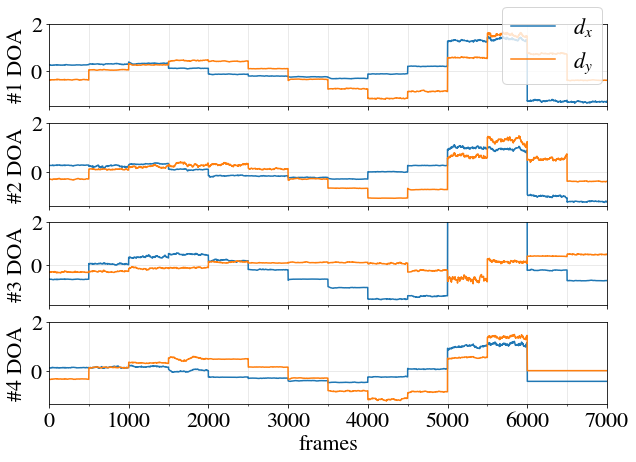

In [3]:
#GET TRAINING DATA
MultiarrayDoaDataset=reload(sys.modules['utils']).MultiarrayDoaDataset

tag = filepath.split('/')[-1].split('.')[0]
tag='revision'

training_data    = MultiarrayDoaDataset(filepath, TRAINING_POINTS, 
                                        out_dim, filter_array_idx, 
                                        b_divide_by_z = True,
                                        testset_split = DOAS_PER_CPOINT)
training_zref    = training_data.calib_xy[training_data.calib_id][:,2]
train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)

if out_dim > training_data.calib_doa.shape[1]: #"one array can not localize 3d"
    out_dim = np.min([out_dim,training_data.calib_doa.shape[1]]) 
    print("underdetermined problem, fewer ins than outs. reducing outs")

# inspect training data
print("mean", np.nanmean(training_data.calib_doa))
print("min", np.nanmin(training_data.calib_doa))
print("max", np.nanmax(training_data.calib_doa))
print("sshape", training_data.calib_doa.shape)

n0,n1 = 0,None
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
training_labels = ["P1","P2","P3","P4","P5","P6"]
numplots = 7-len(filter_array_idx) # arrays
for jj in range(numplots):
    ax = plt.subplot(numplots,1,jj+1)
    oold = [0]
    for tmp in [
            training_data.calib_doa[  :100],
            training_data.calib_doa[100:200],
            training_data.calib_doa[200:],
        ]:
        oold.append(oold[-1]+len(tmp))
        if oold[-2] == 0:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj],label='$d_x$')
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],label='$d_y$')
        else:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj]  ,'C0')
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],'C1')
    #[ax.axvline(oo,c='k') for oo in oold]
    plt.xlim([oold[0],oold[-1]])
    if ax.get_ylim()[0]>-1: ax.set_ylim([-1,ax.get_ylim()[1]])
    if ax.get_ylim()[0]< 2: ax.set_ylim([ax.get_ylim()[0],2])
    ax.set_ylabel("#{} DOA".format(training_data.arrays[jj]),x=-2.20)
    ax.set_xticks(np.arange(oold[0],oold[-1],1000), minor=True)
    ax.set_xticks(np.arange(oold[0],oold[-1],500), minor=True)
    plt.grid(True,which='both')
    if jj == 0:
        #[ax.annotate(training_labels[ii],(oo/oold[-1]+.01,1.05),xycoords='axes fraction') 
        #    for ii,oo in enumerate(oold[:-1])]
        plt.legend(ncol=1,loc='upper right',bbox_to_anchor = (1.01,1.34))
    if jj+1<numplots: ax.set_xticklabels([])
    else: ax.set_xlabel('frames')
#plt.savefig('./fig/'+tag+'_training_data_allpoints.pdf',bbox_inches='tight', pad_inches=0)

In [4]:
# GET TEST DATA
get_test_data=reload(sys.modules['utils']).get_test_data

test_keys =  [
        'rectangle', 
        'inner', # renamed to screen in function
        'counter',
        #'ground', # point, z = floor
        'window', #point
        'door', # point
    
        # ## cleaned also
        # 'outer', 
        # 'table1', # smooth
        # 'MR', # suspect monitor points
        # 'ML', 

        # neither clean nor included
        # 'table4', 'table2', 'table3',  'table5',  'table6', # disturbed
        # 'TR', 'TL', 'L2R', 'R2L', 
        # 'CL', 'CR', 'cR2L', 'cL2R',  
    ]
test_cases, test_labels, test_zref = get_test_data(
    filepath, out_dim, test_keys=test_keys,
    remove_array_idx=filter_array_idx,
    doa_offset=training_data.calib_doa_offset,
    b_divide_by_z = True,
    testset_split=DOAS_PER_CPOINT,
)

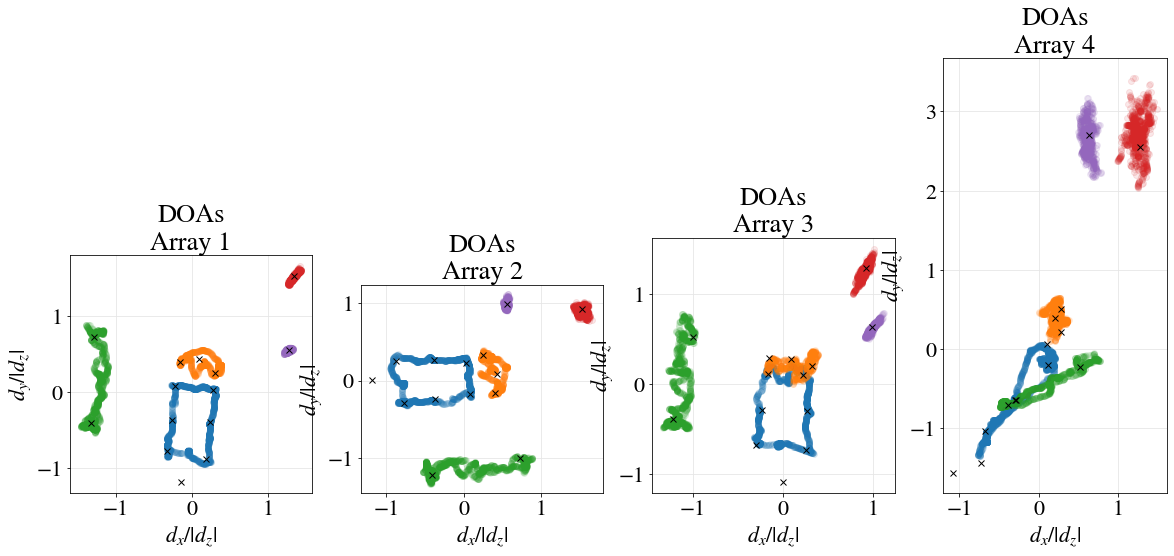

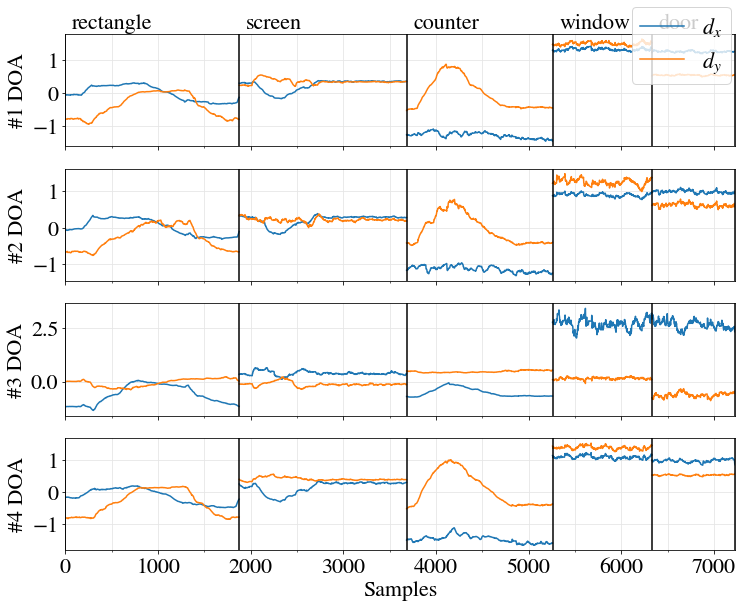

In [5]:
# inspect calibration points vs training or test data series
# tmp = test_all[n0:n1,:]
# tmp = training_data.calib_doa

Na = training_data.N_arrays
numplots = np.min([7,Na])

plt.figure(figsize=(20,8))
cpointdata = 1/np.array([
    np.nanmean(1/training_data.calib_doa[training_data.calib_id == ii],axis=0) 
    for ii in range(training_data.N_points)])
jj = 0
for ii in range(numplots):
    ax = plt.subplot(1,numplots,ii+1)
    while (np.all(np.isnan(cpointdata[:,jj])) | np.all(cpointdata[:,jj]==0)): jj+=1
    for tmp in test_cases:
        ax.plot(tmp[:,jj],tmp[:,jj+1],'o',alpha=.1)
    ax.plot(cpointdata[:,jj],cpointdata[:,jj+1],'kx')
    ax.set_title("DOAs\nArray {}".format(training_data.arrays[jj]))
    ax.set_xlabel('$d_x/|d_z|$')
    ax.set_ylabel('$d_y/|d_z|$')
    ax.set_aspect('equal')
    ax.set_anchor('SW')
    plt.grid()
    jj +=1

plt.figure(figsize=(12,9.5))
for jj in range(numplots):
    ax = plt.subplot(numplots,1,jj+1)
    oold = [0]
    for tmp in test_cases:
        oold.append(oold[-1]+len(tmp))
        if oold[-2] == 0:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj],label="$d_x$")
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],label='$d_y$')
        else:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj]  ,'C0')
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],'C1')
    [ax.axvline(oo,c='k') for oo in oold]
    plt.xlim([oold[0],oold[-1]])
    if ax.get_ylim()[0]>-1:
        ax.set_ylim([-1,ax.get_ylim()[1]])
    ax.set_ylabel("#{} DOA".format(training_data.arrays[jj]),x=-2.20)
    #ax.set_xticks(oold+[1000,3000,4500],minor=False)
    ax.set_xticks(np.arange(oold[0],oold[-1],1000), minor=True)
    ax.set_xticks(np.arange(oold[0],oold[-1],500), minor=True)
    plt.grid(True,which='both')
    if jj == 0:
        [ax.annotate(test_labels[ii],(oo/oold[-1]+.01,1.05),xycoords='axes fraction') 
             for ii,oo in enumerate(oold[:-1])]
        plt.legend(ncol=1,loc='upper right',bbox_to_anchor = (1.01,1.34))
    if jj+1<numplots: ax.set_xticklabels([])
    else: ax.set_xlabel('Samples')
#plt.savefig('./fig/'+tag+'_test_data_allpoints.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

### Build and train neural network

In [6]:
from torch import nn
class NN(nn.Module):
    def __init__(self, N_in, N_out):
        super(NN, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(N_in, 2*N_in),
            nn.ReLU(),
            nn.Linear(2*N_in, 2*N_in),
            nn.ReLU(),
            nn.Linear(2*N_in, 2*N_in),
            nn.ReLU(),
            nn.Linear(2*N_in, 2*N_in),
            nn.ReLU(),
            nn.Linear(2*N_in, N_in),
            nn.ReLU(),
            nn.Linear(N_in, N_out),
        )
        
    def forward(self, x):
        return self.linear_stack(x)

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    mse = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mse += loss.item()
        #if batch % 2000 == 0:
            #loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return mse
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f}")

In [8]:
learning_rate = 1e-3
batch_size = 200
num_epochs = 2000
weight_decay=.0005 #somewhat equal to truncated svd in the linear case
#weight_decay=0 # no regularization
b_truncate_training_data_nn = False

training_data    = MultiarrayDoaDataset(filepath, TRAINING_POINTS, out_dim, filter_array_idx, testset_split=DOAS_PER_CPOINT)
train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)
if b_truncate_training_data_nn:
    _,_, U,sigma ,VH = affine_transform(
        training_data.calib_doa.T, 
        training_data.calib_xy[training_data.calib_id].T, 
        trunc = LM_TRUNC) 
    training_data.calib_doa = ((U[:,:LM_TRUNC]@np.diag(sigma[:LM_TRUNC]))@VH[:LM_TRUNC]).T

network = NN(training_data.calib_doa.shape[1],out_dim)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

/home/manu/mpl/jel_code/utils.py:224: RuntimeWarning: invalid value encountered in true_divide
  self.calib_doa[:,3*ii:3*ii+2] / self.calib_doa[:,3*ii+2,np.newaxis] for ii in range(int(self.calib_doa.shape[1]/3)) ])


In [9]:
model_path = f"./trained_network.pt"
print(network)
if False: # train model
    train_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        train_loss[t] = train_loop(train_dataloader, network, loss_fn, optimizer)
        print(f"[{t:>5d}/{num_epochs:>5d}] avg train loss: {train_loss[t]:>7f}")#, test loss: {test_loss[t]:>7f}")
    print("Training done!")
    plt.semilogy(train_loss)
    plt.savefig('training_mse_loss.pdf')
    torch.save(network.state_dict(),model_path)
else: #load model
    #torch.save(network.state_dict(),model_path)
    network.load_state_dict(torch.load(model_path))
    network.eval()

NN(
  (linear_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): ReLU()
    (10): Linear(in_features=8, out_features=3, bias=True)
  )
)


mkdir: cannot create directory ‘./fig/’: File exists
MSE training:  0.0008565295083182198


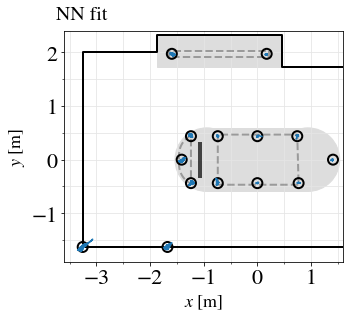

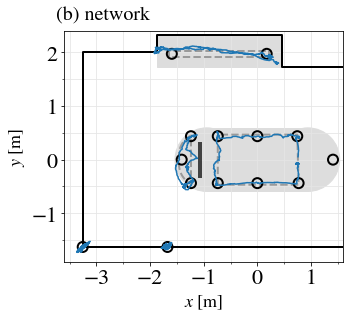

In [10]:
!mkdir ./fig/
show_localization=reload(sys.modules['utils']).show_localization
affine_transform=reload(sys.modules['utils']).affine_transform

layers = [x.data for x in network.parameters()]
opts = dict(ylims=[-1.9,2.4], xlims=[-3.6,1.6], lopts = dict(bbox_to_anchor=(1.1,1.1)))

nid = np.unique(training_data.calib_id)
cdlist = [training_data.calib_doa[training_data.calib_id == ii] for ii in nid]
nn_fit = [network(torch.Tensor(cd)).detach().numpy() for cd in cdlist]
reference = training_data.calib_xy[training_data.calib_id]
print("MSE training: ", np.sum((np.vstack(nn_fit)-reference)**2)/len(reference))
show_localization(nn_fit, training_data, 'C0', **opts, title="NN fit")

network_predictions = [network(test_data).detach() for test_data in test_cases]
show_localization(network_predictions, training_data, **opts,title='(b) network') #label= test_keys,
plt.show()

## LA model

(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 2.2297387e-01 2.6769433e-02 1.0319170e-02 9.1092642e-03
 6.1897780e-03 5.9913372e-04 2.9752421e-04] 
 - condition number: 3361.071
 - kept singular values [1.         0.22297387 0.02676943] 
 - new condition number: 37.356037
MSE training:  0.01969230215890067


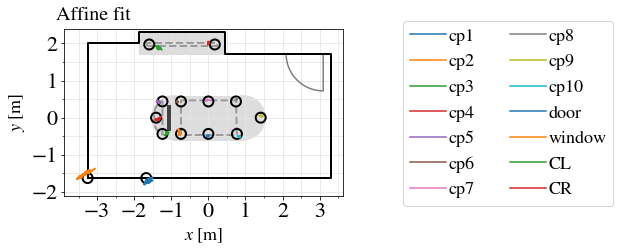

In [11]:
# SETTING MACROS
LM_TRUNC = out_dim # automatically adjusted to 2 for one array
#LM_TRUNC = None # NO TRUNCATION

# SETTING RCOND OVERWRITES TRUNC
#RCOND = .01 # truncate singular vectors < .01 (normalized by maximum)
RCOND = None

B, R_0, U,sigma ,VH = affine_transform(
    training_data.calib_doa.T, 
    training_data.calib_xy[training_data.calib_id].T, 
    trunc = LM_TRUNC,
    rcond = RCOND,
)

affine_predict = lambda doa: (R_0 + B @ doa.T).T

# Analyze fit
affine_fit = [affine_predict(training_data.calib_doa[training_data.calib_id==ii]) for ii in np.unique(training_data.calib_id)]
reference = training_data.calib_xy[training_data.calib_id]
print("MSE training: ", np.sum((np.vstack(affine_fit)-reference)**2)/len(reference))
label= [f'CP{ii}' for ii in range(len(TRAINING_POINTS))] 
label= [training_data.calib_keys[ii] for ii in TRAINING_POINTS] 
show_localization(affine_fit, training_data, label=label,
                  title='Affine fit', ylims=[-2.1,2.4],
                  lopts=dict(ncol=2,bbox_to_anchor=(2.0,1.1)))
plt.savefig('./fig/'+tag+'_affine_allpoints_fit.pdf',bbox_inches='tight',pad_inches=0)

# # predict test data localizations
# affine_predictions = [affine_predict(td.numpy()) for td in test_cases]
# opts = {'ylims':[-2.4,2.8],'xlims':[-4.1,5.2]}
# show_localization(affine_predictions, training_data, label=test_labels ,**opts,lopts=dict(title='4 arrays'))
# plt.savefig('./fig/'+tag+'_affine_allpoints.pdf',bbox_inches='tight', pad_inches=0)
# plt.show()

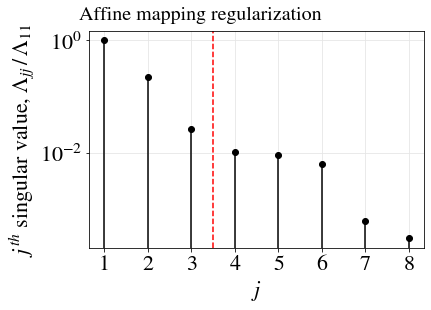

In [12]:
plot_singular_values=reload(sys.modules['utils']).plot_singular_values
sv = [1.0000000e+00, 2.2297387e-01 ,2.6769433e-02 ,1.0319170e-02 ,9.1092642e-03,
 6.1897780e-03, 5.9913372e-04, 2.9752421e-04]
plot_singular_values(sv,LM_TRUNC)

In [13]:
## LINEAR MAPPING DEMO CASE FOR ARRAY SUBSETS
def run_test(deactivate_arrays_sequence,b_concat_cases = False, trunc = LM_TRUNC, rcond=RCOND,**data_kwargs): # run test with affine mapping from array subset. input list of 3,4,5,6 to choose which arrays to drop
    predictions = list()
    for jj,deactivate in enumerate(deactivate_arrays_sequence):
        
        # SEPT 29th
        b_divide_by_z = True # [x,y]/z instead of [x,y,z] doa vectors
        filepath = './data/29_Sep2021_allData.p'
        out_dim = 3

        # only full data set for calibration of affine mapping
        filter_array_idx = [1,2,7] # only keep 3,4,5,6
        filter_array_idx += [dd+2 for dd in deactivate] # offset to start at 3...
        training_data    = MultiarrayDoaDataset(filepath, TRAINING_POINTS, out_dim, filter_array_idx, **data_kwargs)
        print(filter_array_idx, training_data.arrays)

        train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)
        #"one array can not localize 3d"
        if trunc is not None and trunc > training_data.calib_doa.shape[1]:
            trunc = np.min([trunc,training_data.calib_doa.shape[1]]) 
            print("underdetermined problem, fewer ins than outs. reduce outs")

        B, R_0, U,sigma ,VH = affine_transform(
            training_data.calib_doa.T, 
            training_data.calib_xy[training_data.calib_id].T, 
            trunc = trunc,
            rcond = rcond,
        ) 
        affine_predict = lambda doa: (R_0 + B @ doa.T).T

        # Analyze fit
        fit = [affine_predict(training_data.calib_doa[training_data.calib_id==ii]) for ii in np.unique(training_data.calib_id)]
        reference = training_data.calib_xy[training_data.calib_id]
        print("MSE training: ", np.sum((np.vstack(fit)-reference)**2)/len(reference))
        #show_localization(fit, 'C{:d}'.format(jj), 'affine mapping fit\nSVD truncated at {:.2f}'.format(rcond), r0=R_0)
        #plt.savefig('./fig/'+tag+'_0_affine_reference_calib.pdf',bbox_inches='tight',pad_inches=0)

        # predict test data localizations
        test_keys =  [ 'rectangle',  'inner',  'counter','window','door']# 'ground'
        test_cases,_,_ = get_test_data(filepath, out_dim, 
                                     test_keys=test_keys, 
                                     remove_array_idx = filter_array_idx, 
                                     doa_offset=training_data.calib_doa_offset,
                                     **data_kwargs)

        test_predictions = [affine_predict(td.numpy()) for td in test_cases]
        if b_concat_cases: predictions.append(np.vstack(test_predictions))
        else: predictions += test_predictions

        # predictions = [affine_predict(td.numpy()) for td in test_cases]
        # opts = {'color':'C{:d}'.format(jj), 'label':'affine mapping prediction\nSVD truncated at {:.2f}'.format(rcond), 'r0':R_0}
        # if jj == 0: axes = show_localization(predictions, **opts)
        # else: axes = show_localization(predictions,axes=axes, **opts)
    return predictions

def list_diff(list1, list2): 
    return (list(set(list1) - set(list2)))

In [14]:
# all arrays, proposed method 
affine_predictions = run_test([[]], b_concat_cases = False, rcond=RCOND, trunc=LM_TRUNC,
                                b_divide_by_z = True, testset_split = DOAS_PER_CPOINT)
affine_predictions3 = run_test([[4]], b_concat_cases = False, rcond=RCOND, trunc=LM_TRUNC,
                                b_divide_by_z = True, testset_split = DOAS_PER_CPOINT)

/home/manu/mpl/jel_code/utils.py:224: RuntimeWarning: invalid value encountered in true_divide
  self.calib_doa[:,3*ii:3*ii+2] / self.calib_doa[:,3*ii+2,np.newaxis] for ii in range(int(self.calib_doa.shape[1]/3)) ])


[1, 2, 7] [1 2 3 4]
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 2.2297387e-01 2.6769433e-02 1.0319170e-02 9.1092642e-03
 6.1897780e-03 5.9913372e-04 2.9752421e-04] 
 - condition number: 3361.071
 - kept singular values [1.         0.22297387 0.02676943] 
 - new condition number: 37.356037
MSE training:  0.01969230215890067
[1, 2, 7, 6] [1 2 3]
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 2.2949718e-01 2.9603790e-02 1.1096232e-02 7.2383077e-04
 4.6945160e-04] 
 - condition number: 2130.145
 - kept singular values [1.         0.22949718 0.02960379] 
 - new condition number: 33.779457
MSE training:  0.017201769147600448


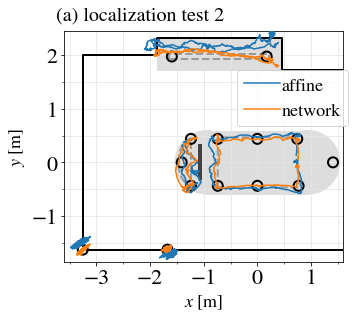

In [15]:
opts = dict( ylims=[-1.85,2.45], xlims=[-3.6,1.6],
            color=[ "C0","C0","C0","C0","C0", "C1","C1","C1","C1","C1", ], )

#from matplotlib.gridspec import GridSpec
#fig = plt.figure(figsize=(9.5,4))
#axes = [fig.add_subplot(gsi) for gsi in GridSpec(1,2,wspace=0.07)]
#show_localization( affine_predictions+affine_predictions3, training_data, **opts, ax=axes[0], 
#                  title='(a) affine mapping', label=["#1-4","","","","","", "#1-3","","","","",""], 
#                  lopts=dict(bbox_to_anchor=(1.05,0.87)))
#show_localization(network_predictions, training_data, **opts, ax=axes[1], title='(b) network')
#plt.ylabel('')
#axes[1].set_yticklabels([])

fig = plt.figure(figsize=(5,5))
show_localization( affine_predictions+network_predictions, training_data, **opts, ax=fig.add_subplot(111), 
                  title='(a) localization test 2', label=["affine","","","","","", "network","","","","",""], 
                  lopts=dict(bbox_to_anchor=(1.05,0.87)))

plt.savefig('./fig/'+tag+'_allpoints.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

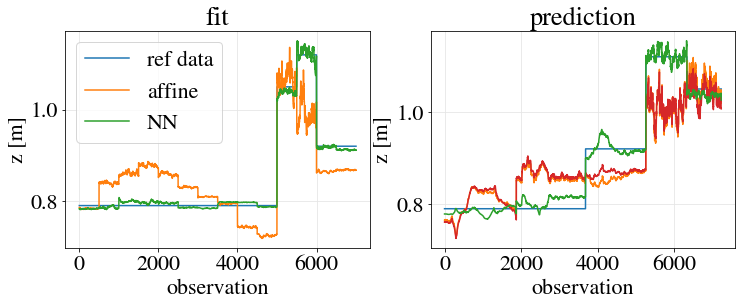

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(training_zref,label='ref data')
plt.plot(np.vstack(affine_fit)[:,2],'C1',label='affine')
plt.plot(np.vstack(nn_fit)[:,2],'C2',label='NN')
plt.ylabel('z [m]')
plt.ylabel('z [m]')
plt.xlabel('observation')
plt.title('fit')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(test_zref,label='reference')
plt.plot(np.vstack(affine_predictions)[:,2],'C1',label='affine')
plt.plot(np.vstack(affine_predictions3)[:,2],'C3',label='affine')
plt.plot(np.vstack(network_predictions)[:,2],'C2',label='NN')
plt.grid()
plt.ylabel('z [m]')
plt.xlabel('observation')
plt.title('prediction')
plt.savefig('./fig/'+tag+'_z.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

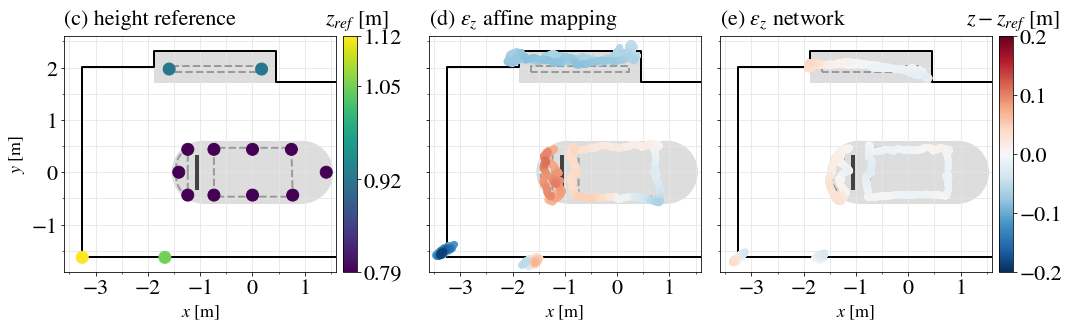

In [17]:
plot_room=reload(sys.modules['utils']).plot_room
afp = np.vstack(affine_predictions).T
nnp = np.vstack(network_predictions).T

from matplotlib.gridspec import GridSpec

def add_cbar(im, ax, dummy=False):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    axsize = ax.bbox._bbox._points_orig
    cax = divider.append_axes('right', size='5%', pad=0.1)
    if dummy:
        cax.set_yticks([])
        cax.axis('off')
    else:
        return plt.colorbar(mappable = im, cax=cax)

ylims=[-1.9,2.6]
xlims=[-3.6,1.6]
fig = plt.figure(figsize=(17,5))
gs = GridSpec(1,3,wspace=.12)

ax = fig.add_subplot(gs[0])
plot_room(ax,training_data.room[:,:2])
pc = plt.scatter(training_data.calib_xy[:,0], training_data.calib_xy[:,1], c=training_data.calib_xy[:,2],
                 vmin=np.min(training_data.calib_xy[:,2]), vmax=np.max(training_data.calib_xy[:,2]),
                 zorder=3,s=144)
plt.text(0,1.05,"(c) height reference",transform=ax.transAxes)
plt.xlim(xlims)
plt.ylim(ylims)
cbar = add_cbar(pc,ax)
cbar.set_ticks(np.unique(training_data.calib_xy[:,2]))
plt.text(1.0,1.05,"$z_{ref}$ [m]",transform=cbar.ax.transAxes,horizontalalignment='center',)

sopts = dict( vmin = -.2, vmax =  .2, cmap = 'RdBu_r', zorder=3)

ax = fig.add_subplot(gs[1])
box = ax.get_position()
box.x0 = box.x0 + 0.03
box.x1 = box.x1 + 0.03
ax.set_position(box)
plot_room(ax,room = training_data.room[:,:2])
error = afp[2]-test_zref
idx = np.argsort(np.abs(error))
error=error[idx]
afp=afp[:,idx]
pc = plt.scatter(afp[0],afp[1],c=error,**sopts)
plt.text(0,1.05,"(d) $\epsilon_z$ affine mapping", transform=ax.transAxes)
plt.xlim(xlims)
plt.ylim(ylims)
plt.ylabel('')
ax.set_yticklabels([])
cbar = add_cbar(pc,ax,dummy=True)
#cbar.set_label("$z-z_{ref}$ [m]")

ax = fig.add_subplot(gs[2])
plot_room(ax,training_data.room[:,:2])
error = nnp[2]-test_zref
idx = np.argsort(np.abs(error))
error=error[idx]
nnp=nnp[:,idx]
pc = plt.scatter(nnp[0],nnp[1],c=error,**sopts)
plt.text(0, 1.05, "(e) $\epsilon_z$ network", transform=ax.transAxes)
plt.xlim(xlims)
plt.ylim(ylims)
plt.ylabel('')
ax.set_yticklabels([])
cbar = add_cbar(pc,ax)
plt.text(1.0,1.05,"$z-z_{ref}$ [m]",transform=cbar.ax.transAxes,horizontalalignment='center',)

plt.savefig('./fig/'+tag+'_z_over_xy.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

Text(0.5, 1.0, 'hist z error NN, mean 0.00')

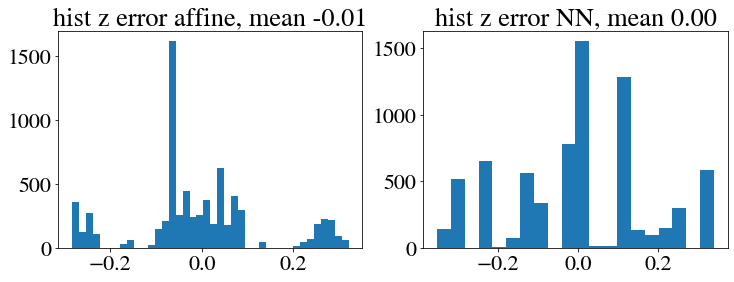

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(121)
afze = afp[2]-test_zref
plt.hist(afze,bins=40)
plt.title('hist z error affine, mean {:.2f}'.format(np.mean(afze)))
plt.subplot(122)
nnze = nnp[2]-test_zref
plt.hist(nnze,bins=20)
plt.title('hist z error NN, mean {:.2f}'.format(np.mean(nnze)))

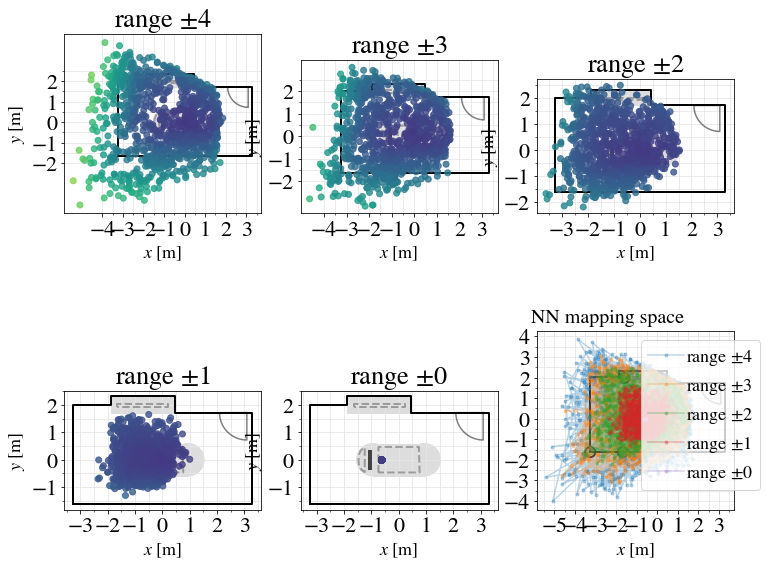

In [19]:
## THROW NOISE IN AND SEE WHERE IT IS MAPPED BY THE NETWORK
ll,uu = 0,5
noisemap = [network(torch.Tensor(np.random.uniform(-jj,jj,(1000,8)))).detach().numpy() for jj in range(ll,uu)]
noisemap.reverse()
label=[f"range $\pm${uu-jj-1}" for jj in range(uu-ll)]

fig = plt.figure(figsize=(12,10))
gs= GridSpec(2,3)
show_localization(noisemap, training_data, ax=fig.add_subplot(gs[-1]),
                  title="NN mapping space",popts=dict(marker='.',alpha=.3),label=label)

vlimm = 0.5
vlimp = 2
for ii,nmap in enumerate(noisemap):
    ax = fig.add_subplot(gs[ii])
    plot_room(ax,training_data.room[:,:2])
    pc = plt.scatter(nmap[:,0],nmap[:,1],c=nmap[:,2],zorder=3,vmin=vlimm, vmax=vlimp,alpha=.8)
    plt.title(label[ii])

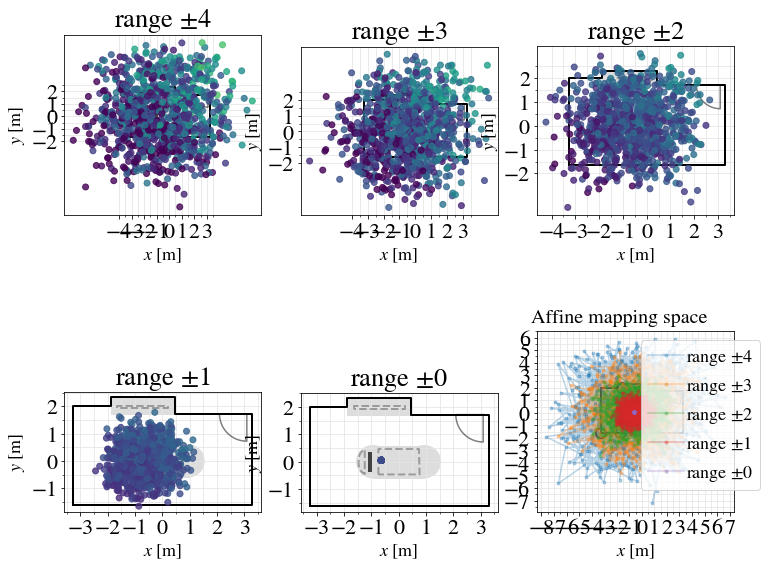

In [20]:
## THROW NOISE AT THE AFFINE MAPPING AND SEE WHERE IT IS MAPPED
ll,uu=0,5
noisemap = [affine_predict(np.random.uniform(-jj,jj,(1000,8))) for jj in range(ll,uu)]
noisemap.reverse()
label=[f"range $\pm${uu-jj-1}" for jj in range(uu-ll)]

fig = plt.figure(figsize=(12,10))
gs= GridSpec(2,3)
show_localization(noisemap, training_data, ax=fig.add_subplot(gs[-1]),
                  title="Affine mapping space",popts=dict(marker='.',alpha=.3),label=label)

vlimm = 0.5
vlimp = 2
for ii,nmap in enumerate(noisemap):
    ax = fig.add_subplot(gs[ii])
    plot_room(ax,training_data.room[:,:2])
    pc = plt.scatter(nmap[:,0],nmap[:,1],c=nmap[:,2],zorder=3,vmin=vlimm, vmax=vlimp,alpha=.8)
    plt.title(label[ii])